# Imports

In [270]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import os
import math

# 2.1 Getting Correspondences and Compute the Homography Parameters

<p>Like 1.1 and 1.2</p>

## Matches

In [271]:
def read_image(image_relative_path):
    root = os.getcwd()
    imgPath = os.path.join(root, image_relative_path)
    
    # read image
    img = cv.imread(imgPath)
    
    return img

In [272]:
def image2gray(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

In [273]:
def SIFT(image):

    # image in gray scale
    imgGray = image2gray(image)

    # create sift
    sift = cv.SIFT_create()

    # find keypoints and descriptors
    keypoints, descriptors = sift.detectAndCompute(imgGray, None)  # binary mask= None (none means don't exclude any pixels)

    # draw keypoints
    imgKeypoints = cv.drawKeypoints(imgGray, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # show image
    plt.imshow(imgKeypoints)
    plt.axis('off')
    plt.title('SIFT Keypoints')
    plt.show()

    return keypoints, descriptors

In [274]:
def knnBruteForce(descriptor1,descriptor2,keypoints1,keypoints2):
    # create brute force matcher
    bf = cv.BFMatcher() # default match is L2 Distance, which is good for SIFT
    nNeighbors = 2
    matches = bf.knnMatch(descriptor1, descriptor2, k=nNeighbors) # get best 2 matches of each key-point is descriptor1
    # matches is best 2 matches in descriptor2 for each key-point in descriptor1

    goodMatches_50 = [None] * 50 # to drawMatchesKnn, it expects a list of lists of DMatch objects
    # DMatch objects hold the two matched points and the distance between them
    src_pts = [None] * 50 # to hold the coordinates of the keypoints in descriptor1
    dst_pts = [None] * 50 # to hold the coordinates of the keypoints in descriptor2
    # we need the coordinates of the keypoints for the homography matrix

    testRatio = 0.3 # ratio test to filter out bad matches (Lowe's ratio test)
    i = 0
    for m, n in matches: # m is best match, and n is second best (m and n are keypoints in img2)
        if m.distance < testRatio * n.distance:
            goodMatches_50[i] = [m] # to drawMatchesKnn, it expects a list of lists of DMatch objects
            src_pts[i] = keypoints1[m.queryIdx].pt # m.queryIdx is the index of the keypoint in descriptor1
            dst_pts[i] = keypoints2[m.trainIdx].pt # m.trainIdx is the index of the keypoint in descriptor2
            i+=1
            if i == 50: # we only want 50 matches
                print("Found 50 good matches")            
                break
    
    return goodMatches_50, src_pts, dst_pts


In [275]:
def drawMatches(img1, img2, kp1, kp2, goodMatches):
    imgMatch = cv.drawMatchesKnn(
        img1, kp1, img2, kp2, goodMatches, None,
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # imgMatch in rgb
    imgMatch = cv.cvtColor(imgMatch, cv.COLOR_BGR2RGB)

    plt.figure()
    plt.imshow(imgMatch)
    plt.axis('off')
    plt.title('Matches')
    plt.show()

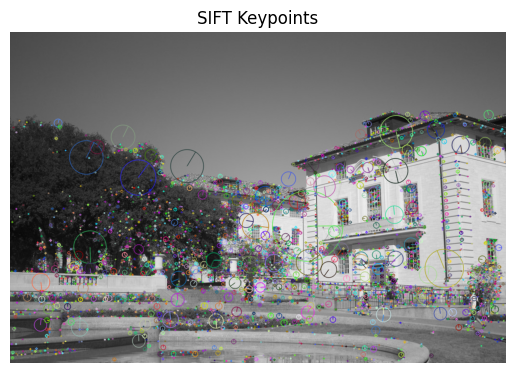

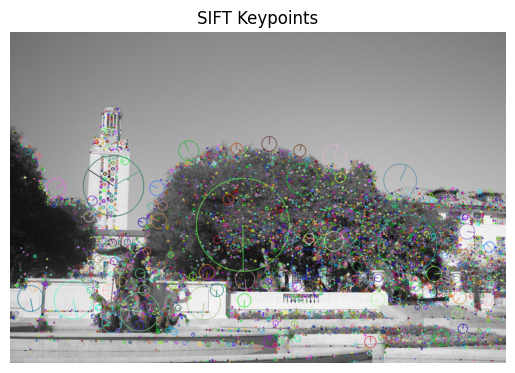

Found 50 good matches


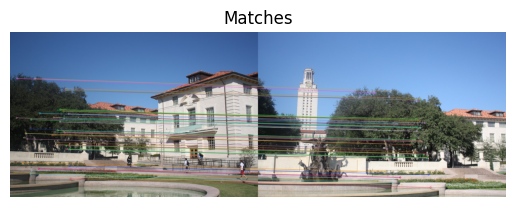

In [276]:
image1 = read_image('assignment_2_materials\\Part_2\\pano_image1.jpg')
image2 = read_image('assignment_2_materials\\Part_2\\pano_image2.jpg')

keypoints1, descriptor1 = SIFT(image1)
keypoints2, descriptor2 = SIFT(image2)

goodMatches, source_points, dest_points = knnBruteForce(descriptor1, descriptor2, keypoints1, keypoints2)
drawMatches(image1, image2, keypoints1, keypoints2, goodMatches)

## Homography Matrix

In [277]:
# SHADI
def compute_homography(src_pts, dst_pts):
    """
    Compute 3x3 homography matrix H such that dst = H * src
    Args:
        src_pts: List of source points [(x1, y1), (x2, y2), ...]
        dst_pts: List of destination points [(x1', y1'), (x2', y2'), ...]
    Returns:
        3x3 homography matrix
    """
    assert len(src_pts) >= 4 and len(src_pts) == len(dst_pts)
    # Solved using Ah = 0
    # Convert to umpy arnrays if they aren't already
    src_pts = np.array(src_pts, dtype=np.float64)   # Ensure float64 for precision
    dst_pts = np.array(dst_pts, dtype=np.float64)

    A = []
    for (x, y), (x_, y_) in zip(src_pts, dst_pts):   # in each iteration we create A_i and append it to A
        A.append([-x, -y, -1, 0, 0, 0, x*x_, y*x_, x_]) # A_i size is 2*9
        A.append([0, 0, 0, -x, -y, -1, x*y_, y*y_, y_]) # for each correspondence we have 1 A_i
        # we said above at least 4 correspondences -> at least 4 A_is

    # N is number of correspondences
    A = np.array(A) # 2N* 9 matrix
    # We need to solve Ah = 0, where h is a vector of size 9

    # Solve using SVD
    U, S, Vt = np.linalg.svd(A) # Singular Value Decomposition: A = USV^T

    '''
    U: Left singular vectors (an orthogonal matrix)
    S: Singular values (diagonal matrix)(a vector of singular values )
    Vt: Right singular vectors (transpose)(transpose of an orthogonal matrix)
    '''

    # The solution h is the last column of V (or last row of Vt)
    h = Vt[-1]

    # Normalize h
    h = h / h[-1] # Dividing by h9 to make it 1

    H = h.reshape((3, 3)) 
    return H

In [278]:
def verify_homography(H, src_pts, dst_pts):
    """Check how well H transforms src_pts to dst_pts"""
    src_hom = np.column_stack([src_pts, np.ones(len(src_pts))]) # Convert to homogeneous coordinates 3*1
    projected = (H @ src_hom.T).T #Applies the homography matrix H to the homogeneous source points
    projected /= projected[:, 2:]  # Normalize to get back to 2D coordinates
    
    errors = np.linalg.norm(projected[:, :2] - dst_pts, axis=1) # Calculate the Euclidean distance between projected points and actual destination points
    print(f"Mean reprojection error: {np.mean(errors):.2f} pixels")
    return errors

In [279]:
# Usage:
H = compute_homography(source_points, dest_points)
errors = verify_homography(H, source_points, dest_points)
H

Mean reprojection error: 0.79 pixels


array([[ 7.69162150e-01,  5.04805259e-02,  4.45561992e+02],
       [-1.37787732e-01,  9.26489747e-01,  7.42700566e+01],
       [-2.14438662e-04, -1.22886996e-05,  1.00000000e+00]])

### Collecting Points For Verification

In [280]:
collected_points = []

def click_event(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        print(f"Point selected: ({x}, {y})")
        collected_points.append((x, y))
        # Optional: show the point on the image
        cv.circle(param, (x, y), 3, (0, 0, 255), -1)
        cv.imshow("Original Image P", param)


# Show image and set callback
image1_copy = image1.copy()
cv.imshow("Original Image P", image1_copy)
cv.setMouseCallback("Original Image P", click_event, image1_copy)

print("Click on the image to select points. Press ESC when done.")

# Wait until ESC key
while True:
    key = cv.waitKey(1) & 0xFF
    if key == 27:  # ESC key
        break

cv.destroyAllWindows()

# Now `collected_points` contains all clicked points
print("Points collected:", collected_points)

Click on the image to select points. Press ESC when done.
Point selected: (581, 272)
Point selected: (105, 592)
Point selected: (309, 492)
Points collected: [(581, 272), (105, 592), (309, 492)]


In [281]:
def map_points(H, src_pts):
    """
    Maps points from src_pts (source points) to dst_pts (destination points)
    using the homography matrix H.
    """
    mapped_pts = []
    for pt in src_pts:
        pt_homogeneous = np.array([pt[0], pt[1], 1])  # Convert to homogeneous coordinates
        mapped_pt = H.dot(pt_homogeneous)  # Apply homography matrix

        # Convert back from homogeneous to non-homogeneous coordinates
        mapped_pt = mapped_pt / mapped_pt[2]  
        mapped_pts.append(mapped_pt[:2])  # Return only x, y coordinates
    return mapped_pts


In [282]:
mapped_points = map_points(H,collected_points)
len(mapped_points)

3

In [283]:
mapped_points = np.array(mapped_points)

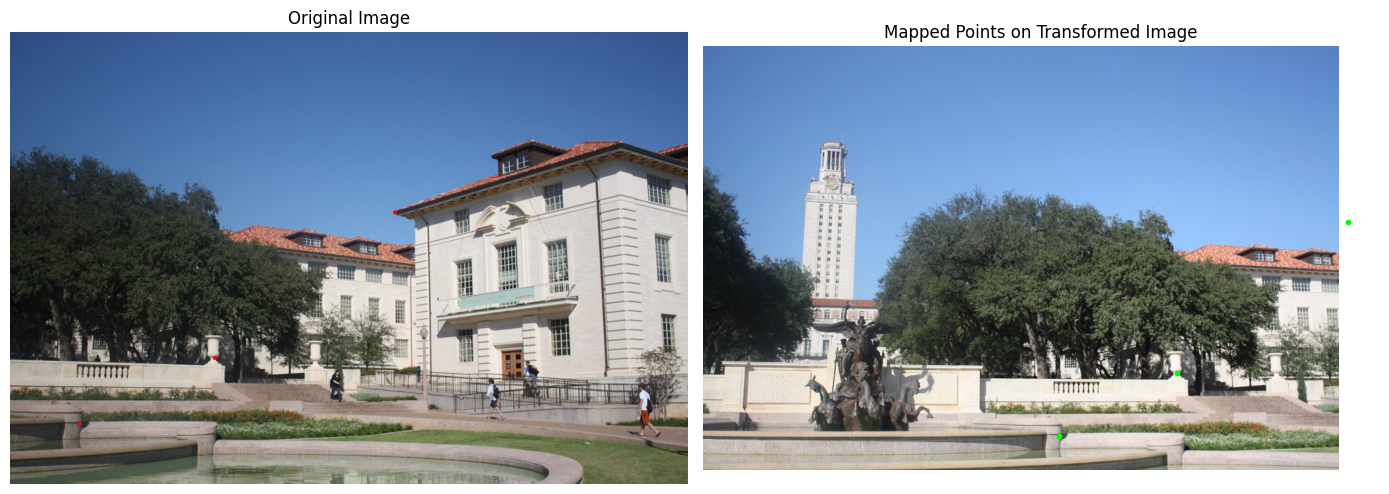

In [284]:
image2_copy = image2.copy()
# Convert BGR to RGB for matplotlib
image2_copy_rgb = cv.cvtColor(image2_copy, cv.COLOR_BGR2RGB)
image1_copy_rgb = cv.cvtColor(image1_copy,cv.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Image 1 (original)
axes[0].imshow(image1_copy_rgb)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Image 2 (transformed with mapped points)
axes[1].imshow(image2_copy_rgb)
axes[1].scatter(mapped_points[:, 0], mapped_points[:, 1], c='lime', marker='o', s=10)
axes[1].set_title("Mapped Points on Transformed Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 2.2 Warping Between Image Planes

Remember, original (p) is image1, and p' is image2, so H takes you from image1 to image2: FORWARD WARPING

INVERSE WARPING is using the inverse of H to take you from p' to p

In [285]:
image1.shape

(683, 1024, 3)

Image 1 has (obviously) 3 channels and height of 683 pixels and width of 1024 pixels 

<p>We will use inverse warping since Forward warping has the problem of HOLES</p>
<p>To use Inverse warping as asked, we will use H inverse from p' image 2 to p in image1. </p>
<p>Now we know where each pixel in p' comes from in p, so we can take the RGB values independently </p>

In [286]:
def apply_H(H, coords):
    pt_homogeneous = np.array([coords[0], coords[1], 1])  # Convert to homogeneous coordinates
    mapped_pt = H.dot(pt_homogeneous)  # Apply homography matrix
    # Convert back from homogeneous to non-homogeneous coordinates
    mapped_pt = mapped_pt / mapped_pt[2]
    mapped_pt = mapped_pt[:2]  # Return only x, y coordinates  
    mapped_pt = np.round(mapped_pt).astype(int)  # Round to nearest integer coordinates
    # Ensure the coordinates are within the image bounds
    #mapped_pt[0] = np.clip(mapped_pt[0], 0, image1.shape[1] - 1)  # x-coordinate


    return mapped_pt

In [287]:
def inverse_homography(H):
    return np.linalg.inv(H)

In [288]:
def get_warped_bounds(original_image,H):
    height_src, width_src = original_image.shape[:2] # exclude channel dimension
    # print(height_src) # 683  y represent row
    # print(width_src) # 1024  x represent column
    
    # row, col in imgs 3adi

    # x , y
    #print(original_image[0,0])
    #print(original_image[0, width_src-1])
    # print(original_image[height_src-1,0])
    # print(original_image[height_src-1, width_src-1])
    # note image origin is at top_left
    
    # Top-left     (x=0, y=0)
    # Bottom-left  (x=0, y=height-1)
    # Top-right    (x=width-1, y=0)
    # Bottom-right (x=width-1, y=height-1)
    # homography acts on x, y: x is col and y is row

    corners_src = [
        [0, 0],                           # top-left
        [0, height_src - 1],             # bottom-left
        [width_src - 1, 0],              # top-right
        [width_src - 1, height_src - 1]  # bottom-right
    ]



    warped_corners = []
    for (x, y) in corners_src:
        # Convert to homogeneous coordinates
        xw, yw, w = H @ [x, y, 1] # @ is matrix multiplication
        warped_corners.append([xw / w, yw / w]) # back to heterogeneous
    
    warped_corners = np.array(warped_corners)
    min_x, min_y = math.floor(min(warped_corners[:,0])), math.floor(min(warped_corners[:,1]))
    max_x, max_y = math.ceil(max(warped_corners[:,0])), math.ceil(max(warped_corners[:,1]))
    #print(min_x)
    #print(min_y)
    out_width = max_x - min_x + 1
    out_height = max_y - min_y + 1
    #print(out_height)
    #print(out_width)
    # print(out_width, out_height,'out_width, out_height')
    output_image = np.zeros((out_height, out_width, 3))
    return output_image,min_x,min_y,warped_corners


In [289]:
def linear_interpolate(x,x0,v0,x1,v1):
    if x1 == x0:
        return v0 
    return v0 + (v1 - v0) * ((x - x0) / (x1 - x0))

In [290]:
# def bilinear_interpolate(input_image, x_src, y_src,c):
#     # x_src and y_src are FLOATS, guranteed to be with in image boundaries
#     # we need to bilinear interpolate to get a pixel value!:::: RGB?
#     # get the four corners of the x_src,y_src
#     # x_floor, x_ceil = math.floor(x_src), math.ceil(x_src)
#     # y_floor, y_ceil = math.floor(y_src), math.ceil(y_src)


#     height, width = input_image.shape[:2]
#     x_floor = int(math.floor(x_src))
#     x_ceil  = min(int(math.ceil(x_src)), width - 1)
#     y_floor = int(math.floor(y_src))
#     y_ceil  = min(int(math.ceil(y_src)), height - 1)

    
#     # note x is width
#     # y is height
#     #       x_floor              x_ceil
#     #y_floor ------------------------------
#     #         -                     -
#     #         -                     -
#     #         -                     -
#     #         -                     -
#     #         -                     -
#     #         -                     -
#     # y_ceil ------------------------------

#     # need to interpolate horizontally at y_floor and at y_ceil
#     # at y_floor
#     vy0 = linear_interpolate(x_src,x_floor,input_image[y_floor,x_floor,c],x_ceil,input_image[y_floor,x_ceil,c])
#     vy1 = linear_interpolate(x_src,x_floor,input_image[y_ceil,x_floor,c],x_ceil,input_image[y_ceil,x_ceil,c])
#     # vy0 and vy1 are the two pixel values at y_floor and y_ceil respectively
#     # then interpolate vertically
#     v = linear_interpolate(y_src,y_floor,vy0,y_ceil,vy1)
#     return v
    

In [291]:
def bilinear_interpolate2(input_image, x_src, y_src, c):
    # Get the four surrounding pixel coordinates
    x0 = int(np.floor(x_src))
    x1 = x0 + 1
    y0 = int(np.floor(y_src))
    y1 = y0 + 1
    
    # Get the interpolation weights
    wx = x_src - x0
    wy = y_src - y0
    
    # Get the pixel values at the four corners
    v00 = input_image[y0, x0, c]
    v10 = input_image[y0, x1, c]
    v01 = input_image[y1, x0, c]
    v11 = input_image[y1, x1, c]
    
    # Interpolate
    value = (1 - wx) * (1 - wy) * v00 + \
            wx * (1 - wy) * v10 + \
            (1 - wx) * wy * v01 + \
            wx * wy * v11
            
    return value

In [292]:
def inverse_warping(H,input_image):
    output_image, min_x,min_y,_ = get_warped_bounds(input_image,H) 
    # output_image rn is empty
    # min_x and min_y are offsets
    
    # now need to inverse warp each pixel in output_image_warped

    # inverse H
    H_inv = inverse_homography(H)

    src_height, src_width,c = input_image.shape
    out_height, out_width,c2 = output_image.shape
    #print("c: ",c)
    if c != c2:
        print("WHAT THE HECK") # delete if not printed

    #print(out_height) # min_y 
    #print(out_width) # min_x
    # y , x


    for y_out in range(out_height):
        for x_out in range(out_width):
            for channel in range(c):
                x_dst = x_out + min_x
                y_dst = y_out + min_y
                
                # Warp destination point back to source using inverse homography
                x_src, y_src, w = H_inv @ [x_dst, y_dst, 1]
                x_src /= w
                y_src /= w


                if 0 <= x_src < src_width-1 and 0 <= y_src < src_height-1: # if the source we got form inverse warping exists
                    # Bilinear interpolate pixel value at (x_src, y_src)
                    num = bilinear_interpolate2(input_image, x_src, y_src,channel)
                    #print(num)
                    output_image[y_out, x_out,channel] = num 
                else:
                    output_image[y_out, x_out,channel] = 0  # black (nn since it started out empty but just in case ig)
    
    return output_image

In [293]:
# def forward(H,image):
#     # image dimensions
#     h, w, c= image.shape

#     # to warp we need an empty image to put results into it
#     # empty image with same size as image
#     imgWarp = np.zeros((2*h, 2*w, c), dtype=np.uint8) # 0s in all pixels

#     # warp the image using the homography matrix H
#     for i in range(h):
#         for j in range(w):
#             # for each pixel
#             new_coords = apply_H(H, (i,j)) # apply H to get new coords
#             # we know this new coords pixel value should come from i,j
#             for channel in range(c):
#                 # for each channel
#                 imgWarp[int(new_coords[0]), int(new_coords[1]),channel] = image[i,j,channel]

#     return imgWarp

In [294]:
# new_image = forward(H,image1)

# # Convert BGR to RGB for correct color display in matplotlib
# image_rgb = cv.cvtColor(new_image, cv.COLOR_BGR2RGB)

# plt.imshow(image_rgb)
# plt.title("My Image")
# plt.axis('off')  # Hide axes
# plt.show()

In [295]:
def warp(H, image):
    output = inverse_warping(H,image)
    output = np.clip(output, 0, 255).astype(np.uint8)
    # Convert BGR to RGB for correct color display in matplotlib
    image_rgb = cv.cvtColor(output, cv.COLOR_BGR2RGB)

    # plt.imshow(image_rgb)
    # plt.title("My Image")
    # plt.axis('off')  # Hide axes
    # plt.show()
    
    #plt.imshow(output.astype(np.uint8))
    # return new image that is warp of the input image using H
    return output

In [296]:
# output = warp(H,image1)
# output

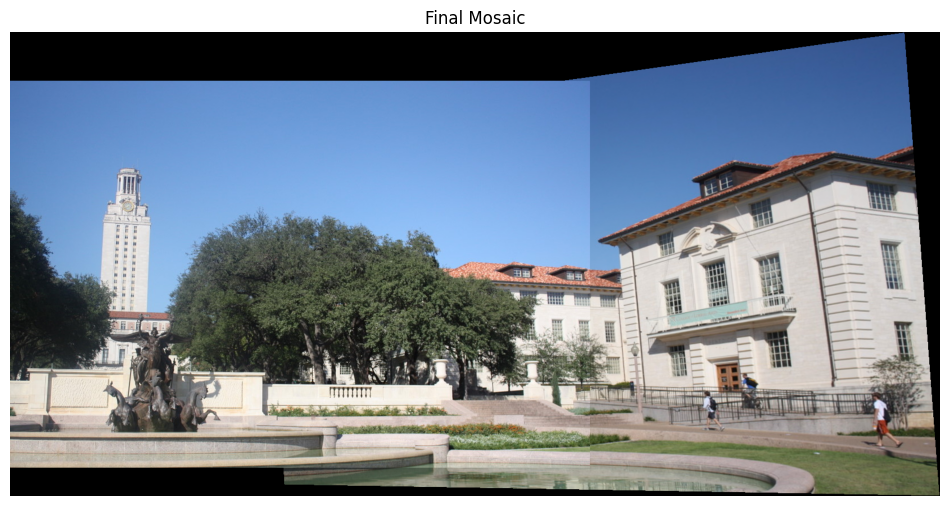

In [297]:
def create_mosaic(img1, img2, H):
    # Warp image 2 into image 1's frame
    warped_img2, min_x2, min_y2,warped_corners2 = get_warped_bounds(img2, H)
    warped_img2 = inverse_warping(H, img2)
    warped_img2 = np.clip(warped_img2, 0, 255).astype(np.uint8)

    # Image 1 stays in original frame, but we may need to place it into the same mosaic
    h1, w1 = img1.shape[:2]

    # Compute image 1 corners and overall bounds with image 2
    corners_img1 = np.array([
        [0, 0],
        [0, h1 - 1],
        [w1 - 1, 0],
        [w1 - 1, h1 - 1]
    ])
    all_corners = []

    for (x, y) in corners_img1:
        all_corners.append([x, y])
    # warped_corners2 = []
    # for (x, y) in [[0, 0], [0, img2.shape[0]-1], [img2.shape[1]-1, 0], [img2.shape[1]-1, img2.shape[0]-1]]:
    #     xw, yw, w = H @ [x, y, 1]
    #     warped_corners2.append([xw / w, yw / w])
    all_corners.extend(warped_corners2)

    all_corners = np.array(all_corners)
    min_x = int(np.floor(np.min(all_corners[:, 0])))
    max_x = int(np.ceil(np.max(all_corners[:, 0])))
    min_y = int(np.floor(np.min(all_corners[:, 1])))
    max_y = int(np.ceil(np.max(all_corners[:, 1])))
    # print(min_x,max_x,min_y,max_y," min x, max x, min y, max y")

    mosaic_width = max_x - min_x + 1
    mosaic_height = max_y - min_y + 1

    # Offsets to shift images into positive coordinates
    offset_x = -min_x #after warping image2, may be negative
    offset_y = -min_y

    # Create empty canvas
    mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)

    # Place img1 into mosaic
    for y in range(h1):
        for x in range(w1):
            pixel = img1[y, x]
            if not np.all(pixel == 0):
                mosaic[y + offset_y, x + offset_x] = pixel # # Place image 1 in the correct position

    # Place warped img2 into mosaic
    h2, w2 = warped_img2.shape[:2]
    for y in range(h2):
        for x in range(w2):
            pixel = warped_img2[y, x]
            if not np.all(pixel == 0): ## Only overwrite non-black pixels
                # Coordinates of warped image 2 are already aligned in img1's frame
                mosaic_y = y + min_y2 + offset_y 
                mosaic_x = x + min_x2 + offset_x
                if 0 <= mosaic_y < mosaic_height and 0 <= mosaic_x < mosaic_width: # check bounds
                    if np.all(mosaic[mosaic_y, mosaic_x] == 0): # Only overwrite if the pixel is black (0,0,0)
                        mosaic[mosaic_y, mosaic_x] = pixel # copying each non-black pixel from the warped version of image2
                    # blend instead of overwrite
                    # else:
                    #     mosaic[mosaic_y, mosaic_x] = (mosaic[mosaic_y, mosaic_x] // 2 + pixel // 2)

    return mosaic

H = np.array(H, dtype=np.float64)
mosaic = create_mosaic(image2, image1, H) 

# Show result
plt.figure(figsize=(12, 8))
plt.imshow(cv.cvtColor(mosaic, cv.COLOR_BGR2RGB))
plt.title("Final Mosaic")
plt.axis('off')
plt.show()

Stitching completed successfully.


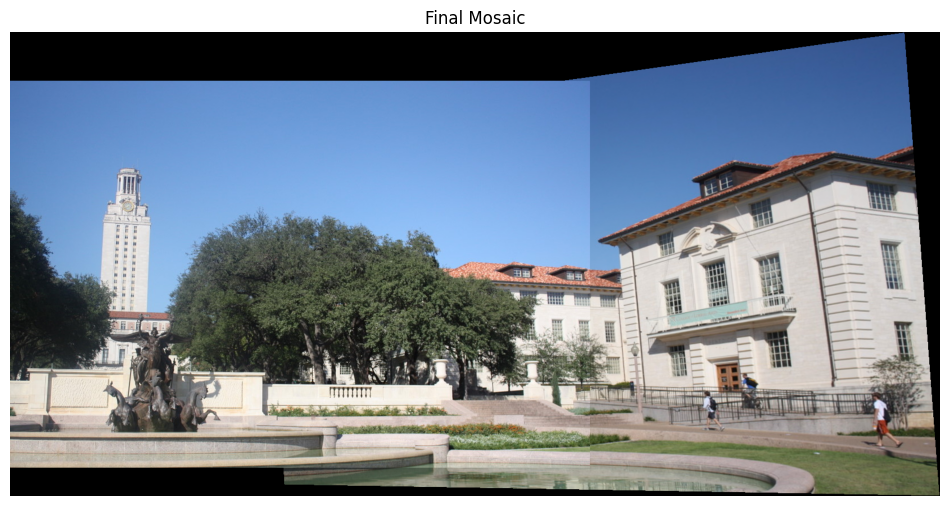

In [298]:
#built in stitching
stitcher = cv.Stitcher_create()
status, stitched = stitcher.stitch([image1, image2])
if status == cv.Stitcher_OK:
    print("Stitching completed successfully.")
    plt.figure(figsize=(12, 8))
    plt.imshow(cv.cvtColor(mosaic, cv.COLOR_BGR2RGB))
    plt.title("Final Mosaic")
    plt.axis('off')
    plt.show()
    # cv.imshow("Stitched Image", stitched)
    # cv.waitKey(0)
